In [3]:
# setup
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
display(HTML(open('rise.css').read()))

# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})


# CMPS 2200
# Introduction to Algorithms

## Review & Functional Language



### Using $p$ processors

$$T_p \leq \frac{T_1}{p} + T_\infty$$
$$T_p \in O(\frac{T_1}{p} + T_\infty)$$

### Amdahl's Law

- Let $T_1$ be the total time of the parallel algorithm on one processor. Let's set this value to 1.
- Let $S$ be the amount of time that cannot be parallelized.
- Assume (generously) that the remaining time (1-S) gets perfect speedup using $p$ processors.
- Then we have

$T_1 = S + (1-S) = 1, ~~T_P = S + \dfrac{(1-S)}{p}~~~\Rightarrow~~~~\dfrac{T_1}{T_p} = \dfrac{1}{S + \dfrac{1 − S}{p}}$

speedup using $p$ processors is limited by the fraction of the algorithm that is parallelizable.

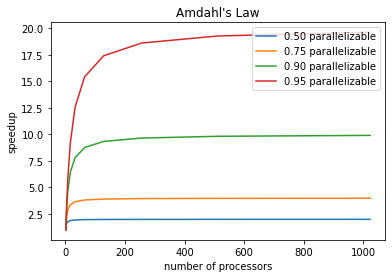

In [4]:
# plot amdahl's law
import matplotlib.pyplot as plt
processors = [1,2,4,8,16,32,64,128,256,512,1024]
parallel_portions = [.5, .75, .9, .95]
plt.figure()
for parallel_portion in parallel_portions:
    S = 1 - parallel_portion
    speedups = [1 / (S + (1-S)/p) for p in processors]
    plt.plot(processors, speedups, label='%.2f parallelizable' % parallel_portion)
plt.legend()
plt.ylabel('speedup')
plt.xlabel('number of processors')
plt.title("Amdahl's Law")
plt.show()
        

**Algorithm specification**: defines what an algorithm should do.

> Given a sequence $A$ of $n$ elements, return a sequence $B$ such that $B[i] \leq B[j]$ for all $0 \leq i \le j \le n$

May also include **cost specification**, e.g. $O(n \log n)$ work and $O(\log^2 n)$ span.

<br>

**Algorithm implementation** (or just **algorithm**): defines **how** an algorithm works.

This could be real, working code, or pseudo-code.

Our textbook uses a pseudo code language called **SPARC**

When possible, we will also show Python versions of key algorithms.



## Functional languages

In functional languages, functions act like mathematical functions.

Two key properties:

1. function maps an input to an output $f : X \mapsto Y$: no **side effects**
    
2. function can be treated as values: **function A can be passed to function B**

## Functions as values

Many languages allow functions to be passed to other functions.

Functions as "first-class values."

In [5]:
def double(value):
    return 2 * value

def double_and_sum(double_fn, vals):
    total = 0
    for v in vals:
        total += double_fn(v)
    return total

# pass the function double to the function double_and_sum
double_and_sum(double, [1,2,3]) 
# 1*2 + 2*2 + 3*2

12

`double_and_sum` is called a **higher-order function**, since it takes another function as input.

Why is this useful?

In [8]:
def map_function(function, values):
    for v in values:
        yield function(v)

list(map_function(double, [1,2,3]))

[2, 4, 6]

In [9]:
def square(value):
    return value * value

list(map_function(square, [1,2,3]))

[1, 4, 9]

In [10]:
list(map_function(double, map_function(square, [1,2,3])))

[2, 8, 18]

- If we know that `function` is pure, then we can trivially parallelize `map_function` for many inputs.



- By using higher-order functions, we can define a few primitive, high-order functions that will make it easier to reason about and analyze run-time of parallel computations.

## Algorithmic Cost  Models

- Define a language to specify algorithms
- Assign a cost to each expression
- Cost of algorithm is sum of costs for each expression

## Language based Work-Span model

Recall our definitions of **work** and **span**

> **work**: total number of primitive operations performed by an algorithm

> **span**: longest sequence of dependencies in computation
- time to run with an infinite number of processors
- measure of how "parallelized" an algorithm is 
- also called: *critical path length* or *computational depth*

<br>

**intuition**:  
**work**: total energy consumed by a computation  
**span**: minimum possible time that the computation requires

<br>
        
**work**: $T_1$ = time using one processor  
**span**: $T_\infty$ = time using $\infty$ processors

For a given expression $e$ [a series of statements], we will analyze the work $W(e)$ and span $S(e)$

## SPARC Example 


<br><br>
<p> <span>\[\begin{array}{l}  
\texttt{let}\\   
~~~~x = 2 + 3\\  
~~~~f (w) = (w * 4, w - 2)\\  
~~~~(y,z) = f(x-1)\\  
\texttt{in}\\   
~~~~x + y + z\\  
\texttt{end}   
\end{array}\]</span></p>
<br><br>
$x = 2 + 3 = 5$  
$f(4) \rightarrow (16, 2)$  
$x + y + z= 5 + 16 + 2 = 23$

<br><br>
**binding**: associate entities (data or code) with identifiers.

<br>

**let expression:**

**let**  
$\:\: b^+$  
**in**  
$\:\:e$  
**end**

Expression $e$ is applied using the bindings defined inside **let**.

<br><br>
**expression** *e*: describes a computation  
- **evaluating** an expression produces its value






> What does this do?
<br><br>
<p> <span>\[\begin{array}{l}  
\texttt{let}\\   
~~~~f(i)=\texttt{if}~(i<2) \\
~~~~~~~~~~~~~~~~~~~~~\texttt{𝚝𝚑𝚎𝚗}~i \\
~~~~~~~~~~~~~~~~~\texttt{𝚎𝚕𝚜𝚎}\\
~~~~~~~~~~~~~~~~~~~~~~i*f(i-1) \\
\texttt{in}\\   
~~~~f(5)\\  
\texttt{end}   
\end{array}\]</span></p>
<br><br>

The expression will evaluate to the factorial of 5, i.e., 5∗4∗3∗2∗1, which is 120.

In [2]:
def factorial(i):
    if i < 2:
        return i
    else:
        return i * factorial(i-1)
factorial(5)

120

## Composition

<img src="figures/composition.png" width="50%"/>


-   $(e_1, e_2)$: Sequential Composition

    -   Add work and span

-   $(e_1 || e_2)$: Parallel Composition

    -   Add work but **take the maximum span**
    
    

### parallel composition: $(e_1 || e_2)$

- $W(e_1 || e_2) = 1 + W(e_1) + W(e_2)$  
- $S(e_1 || e_2) = 1 + \max(S(e_1), S(e_2))$  


### SPARC SumList
<p><span class="math display">\[\begin{array}{l}   
\\\\
\mathit{sumList}~a =   
\\  
~~~~~~~~~\texttt{if}~|a| = 1~\texttt{then}   
\\  
~~~~~~~~~~~~~\texttt{return}~a  
\\  
~~~~~~~~~\texttt{else}  \\
~~~~~~~~~~~~\texttt{let}\\   
~~~~~~~~~~~~~~~~(l, r)=\texttt{splitMid}~a \\
~~~~~~~~~~~~~~~~(l',r')=(\mathit{sumList}~l~||~\mathit{sumList}~r)\\
~~~~~~~~~~~~\texttt{in}\\  
~~~~~~~~~~~~~~~~l'+r'\\
~~~~~~~~~~~~\texttt{end}   
\end{array}\]</span></p>


<!-- <p><span class="math display">\[\begin{array}{l}   
\\\\
\mathit{sumList}~a =   
\\  
~~~~~~~~~\texttt{if}~|a| = 1~\texttt{then}   
\\  
~~~~~~~~~~~~~\texttt{return}~a  
\\  
~~~~~~~~~\texttt{else}  \\
~~~~~~~~~~~~\texttt{let}\\   
~~~~~~~~~~~~~~~~(l, r)=\texttt{splitMid}~a \\
~~~~~~~~~~~~~~~~(l',r')=(\mathit{sumList}~l,~\mathit{sumList}~r)\\
~~~~~~~~~~~~\texttt{in}\\  
~~~~~~~~~~~~~~~~l'+r'\\
~~~~~~~~~~~~\texttt{end}   
\end{array}\]</span></p> -->

In [ ]:
# recursive, serial
def sum_list_recursive(mylist):    
    print('summing %s' % mylist)
    
    if len(mylist) == 1:
        return mylist[0]
    
    return (
        sum_list_recursive(mylist[:len(mylist)//2]) +
        sum_list_recursive(mylist[len(mylist)//2:])
    )

# recursive, parallel
def sum_list_recursive_parallel(mylist):    
    print('summing %s' % mylist)
    if len(mylist) == 1:
        return mylist[0]
    
    # each thread spawns more threads
    result1, result2 = in_parallel(
        sum_list_recursive_parallel, mylist[:len(mylist)//2],
        sum_list_recursive_parallel, mylist[len(mylist)//2:]
    )
    print('>>>merging %s and %s' % (result1, result2))
    return result1 + result2


## Scheduling

Key issue of parallel algorithms is **scheduling**: which processor will run which task when?
- typically have more tasks than processors.

Recall our parallel sum method:

![greedy](figures/dag-sum.png)  
[source](https://homes.cs.washington.edu/~djg/teachingMaterials/spac/sophomoricParallelismAndConcurrency.pdf)



We must decide when to run each part of the sum. There are dependencies that constrain the order.

## Scheduler
- For each task generated by a parallel algorithm, assign it to an available processor
- Goal: minimize execution time.


## Greedy Scheduler

Whenever there is a processor available and a task ready to execute, assign the task to the processor and start it immediately. 

Why might this not be optimal? [Assume you have 3 processors for the below task.]
![greedy](figures/greedy.png)


Greedy schedulers have an important property that is summarized by the greedy scheduling principle.

Assuming $P$ processors, then the time $T_P$ to perform computation with work $W$ and span $S$ is bounded by:

$T_P < \frac{W}{P} + S$


Because we know:  
- $T_P \ge \frac{W}{P}$, since that would be the optimal division of work to processors
- $T_P \ge S = T_\infty$, by the definition of span

we can conclude that the best we can hope for is:

$T_P \ge \mathrm{max}(\frac{W}{P},S)$

Therefore the time using a greedy scheduler is bounded by:

$ \mathrm{max}(\frac{W}{P},S) \le T_P < \frac{W}{P} + S$

<br>
How good is greedy? How close is $(\frac{W}{P} + S)$ to $\mathrm{max}(\frac{W}{P},S)$?


actually pretty close.

> $\frac{W}{P} + S \le 2 * \mathrm{max}(\frac{W}{P},S)$

(why? consider what the worst possible span is...)

<br>

Greedy scheduler gets better the more parallelism is possible in the algorithm.

Recall average parallelism: $\overline{P} = \frac{W}{S}$

We can rewrite:

$T_P < \frac{W}{P} + S$  
$~~~~= \frac{W}{P} + \frac{W}{\overline{P}}$  
$~~~~=\frac{W}{P}(1+\frac{P}{\overline{P}})$


So, the greater $\overline{P}$ is than $P$, the closer to optimal we get.


E.g., recall our parallel sum method, which has

$W=O(n)$  
$S=O(\lg n)$

<br>
$\overline{P} = \frac{W}{S} = \frac{O(n)}{O(\lg n)}$

<br>

$ \mathrm{max}(\frac{W}{P},S) \le T_P < \frac{W}{P} + S$

<br>

so, if we have 2 processors:

$\mathrm{max}(\frac{O(n)}{2},O(\lg n)) \le T_2 < \frac{O(n)}{2} + O(\lg n)$

$\frac{O(n)}{2} \le T_2 < \frac{O(n)}{2} + O(\lg n)$

<br><br><br>

if we have $\lg n$ processors:


$\mathrm{max}(\frac{O(n)}{\lg n},O(\lg n)) \le T_{\lg n} < \frac{O(n)}{\lg n} + O(\lg n)$

$\frac{O(n)}{\lg n} \le T_{\lg n} < \frac{O(n)}{\lg n} + O(\lg n)$




The advantage of the Work-Span model:

- We can design parallel algorithms without worrying about scheduling details.

- We are ignoring some overhead in the creation of the schedule itself.
  - This is acceptable since we are focused on asymptotics (just as in RAM model)